In [5]:
from sklearn.preprocessing import LabelEncoder
import warnings
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import sys
# import pymc3 as pm

warnings.filterwarnings("ignore")
sns.set_theme(style="whitegrid")

test_size=0.3
random_state=42

In [6]:
class BetaEncoder(object):
        
    def __init__(self, group):
        
        self.group = group
        self.stats = None
        
    # get counts from df
    def fit(self, df, target_col):
        # prior mean
        self.prior_mean = np.mean(df[target_col]) 
        stats           = df[[target_col, self.group]].groupby(self.group)
        # count and sum
        stats           = stats.agg(['sum', 'count'])[target_col]    
        stats.rename(columns={'sum': 'n', 'count': 'N'}, inplace=True)
        stats.reset_index(level=0, inplace=True)           
        self.stats      = stats
        
    # extract posterior statistics
    def transform(self, df, stat_type, N_min=1):
        
        df_stats = pd.merge(df[[self.group]], self.stats, how='left')
        n        = df_stats['n'].copy()
        N        = df_stats['N'].copy()
        
        # fill in missing
        nan_indexs    = np.isnan(n)
        n[nan_indexs] = self.prior_mean
        N[nan_indexs] = 1.0
        
        # prior parameters
        N_prior     = np.maximum(N_min-N, 0)
        alpha_prior = self.prior_mean*N_prior
        beta_prior  = (1-self.prior_mean)*N_prior
        
        # posterior parameters
        alpha       =  alpha_prior + n
        beta        =  beta_prior  + N-n
        
        # calculate statistics
        if stat_type=='mean':
            num = alpha
            dem = alpha+beta
                    
        elif stat_type=='mode':
            num = alpha-1
            dem = alpha+beta-2
            
        elif stat_type=='median':
            num = alpha-1/3
            dem = alpha+beta-2/3
        
        elif stat_type=='var':
            num = alpha*beta
            dem = (alpha+beta)**2*(alpha+beta+1)
                    
        elif stat_type=='skewness':
            num = 2*(beta-alpha)*np.sqrt(alpha+beta+1)
            dem = (alpha+beta+2)*np.sqrt(alpha*beta)

        elif stat_type=='kurtosis':
            num = 6*(alpha-beta)**2*(alpha+beta+1) - alpha*beta*(alpha+beta+2)
            dem = alpha*beta*(alpha+beta+2)*(alpha+beta+3)
            
        # replace missing
        value = num/dem
        value[np.isnan(value)] = np.nanmedian(value)
        return value

In [31]:
# set the data type
dtypes = {'city_development_index': 'float', 
          'city':'str',
          'gender':'str',
          'relevent_experience':'str',
          'training_hours': 'float', 
          'target': 'int', 
          'enrolle_id': 'int',
          'city':'str',
          'enrollee_id':'str',
          'enrolled_university':'str',
          'education_level':'str', 
          'major_discipline':'str',
          'experience':'str',
          'company_size':'str',
          'last_new_job':'str'}

# read data
df_train = pd.read_csv("D://HR-Analytics-Job-Change-of-Data-Scientists//data//aug_train.csv", dtype=dtypes)
df_test = pd.read_csv("D://HR-Analytics-Job-Change-of-Data-Scientists//data//aug_train.csv", dtype=dtypes)

# different categorical data
con = ['city_development_index', 'training_hours']
cat = ['gender', 'relevent_experience', 'enrolled_university', 'education_level', 
       'major_discipline', 'experience', 'company_size', 'company_type', 'last_new_job']

df_train.head(3)

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36.0,1
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47.0,0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83.0,0


In [32]:
# missing values
(df_train.isnull().sum()/df_train.shape[0]).sort_values(ascending=False).round(4)[:9]

company_type           0.3205
company_size           0.3099
gender                 0.2353
major_discipline       0.1468
education_level        0.0240
last_new_job           0.0221
enrolled_university    0.0201
experience             0.0034
enrollee_id            0.0000
dtype: float64

In [33]:
def label_encode(train, test):
    """
    encoding the string values. it returns dataframe which are encoded and dictionary object save results.
    
    args:
        train: trainning dataset.
        test: test dataset.
    
    returns:
        train: traning dataset after encoding processes.
        test: test dataset after encoding processes.
        label_dict: the dict object save encoding result. where key repersents column name, and value represent encoding label.
    """
    label_dict = {}
    
    for column in ['city', 'gender', 'education_level', 'major_discipline','experience', 'relevent_experience', 
                   'company_size', 'company_type', 'last_new_job', 'training_hours','enrolled_university']:
        # initialize object
        le = LabelEncoder()
        le.fit(train[column])
        
        label_dict[column] = le.classes_
        
        # transfer columns
        train[column] = le.transform(train[column]).astype(int)
        test[column] = le.transform(test[column]).astype(int)
    return train, test, label_dict

df_train_notna, df_test_notna, labels = label_encode(df_train.dropna(), df_test.dropna())

## Continuous Plot

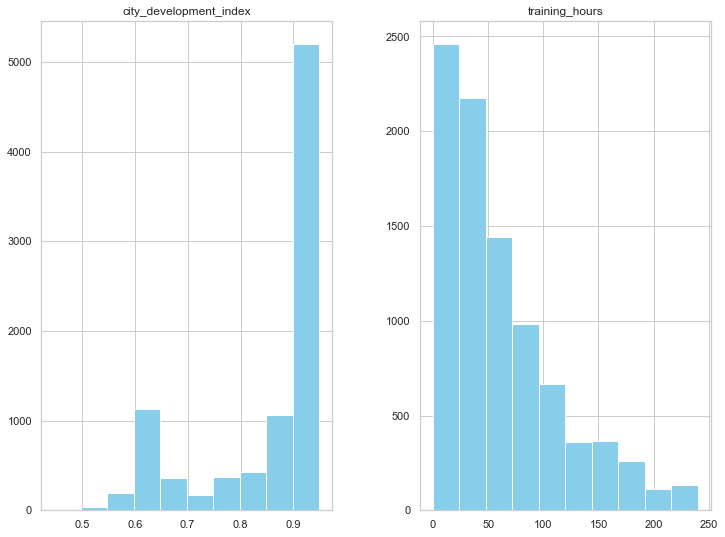

In [34]:
# continuous data
df_train_notna[con].hist(figsize=(12,9), color = "skyblue");

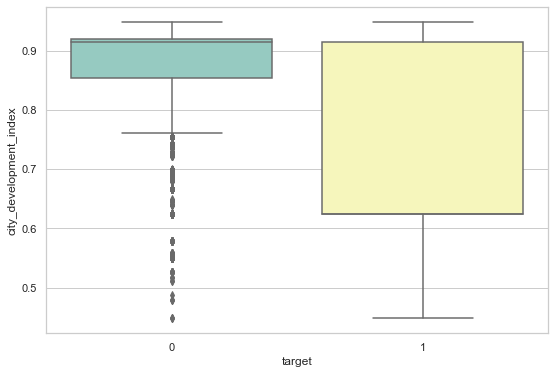

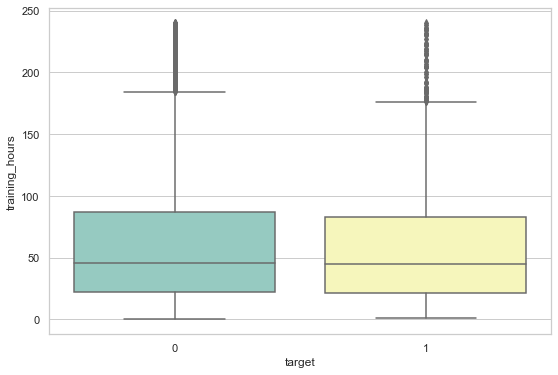

In [35]:
for column in con:
    plt.figure(figsize=[9,6])
    sns.boxplot(x="target", y=column, palette="Set3", data=df_train_notna, orient='v');

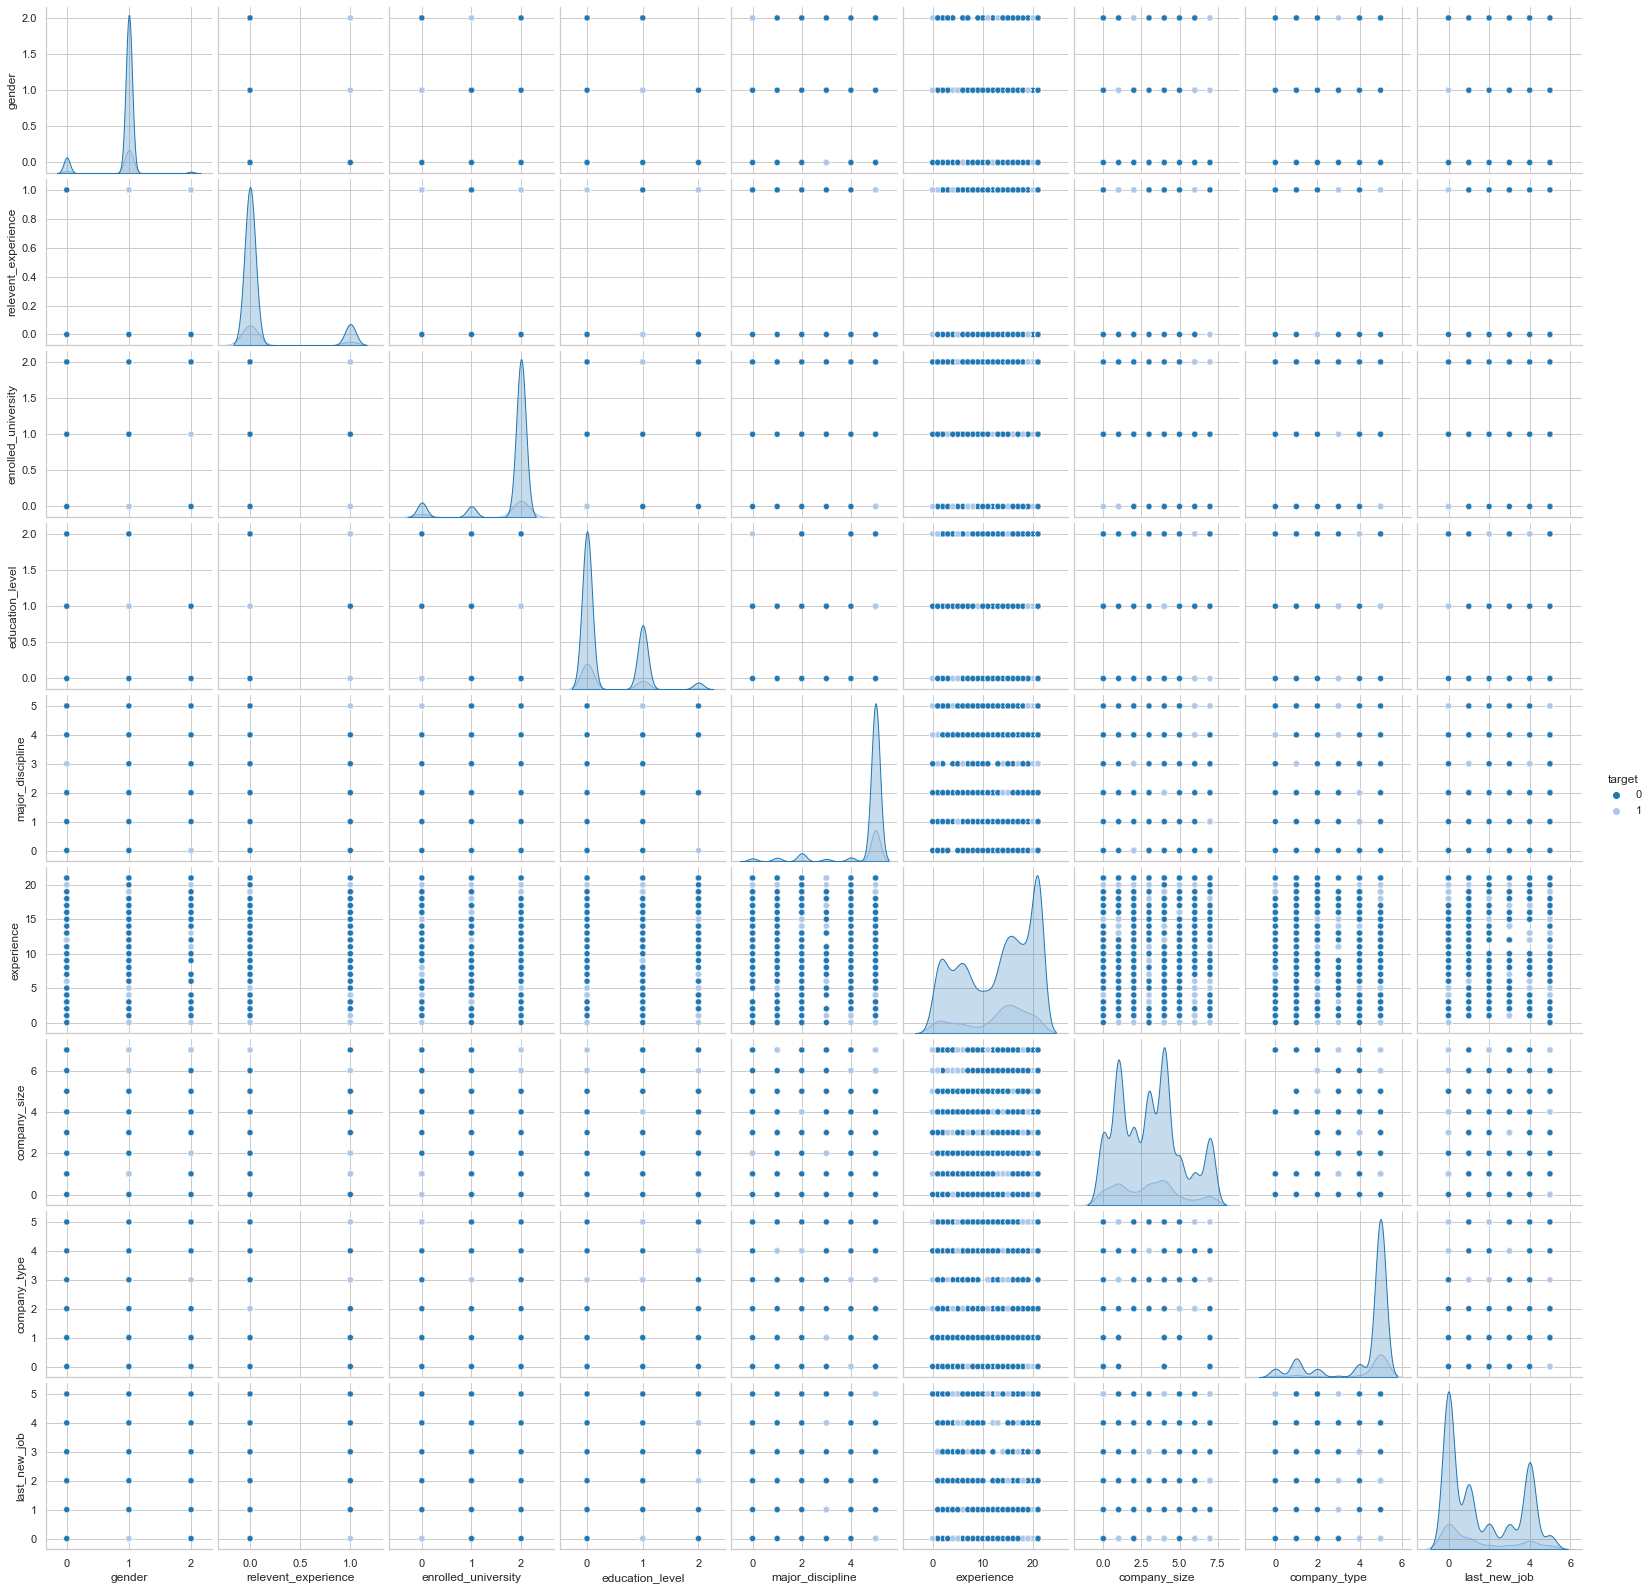

In [39]:
sns.pairplot(df_train_notna[cat+['target']], palette='tab20', hue='target');

In [ ]:
sns.residplot(x="city_development_index",y="target", data=df_train)

In [8]:
def transfer_cat_type(train, test, cat=cat):
    """transfer data type to categoical data, the function return datasets which are categorical values."""
    for column in train[cat].columns:
        train[column] = train[column].astype(int)
        test[column] = test[column].astype(int)
    return train, test 
df_train_notna, df_test_notna = transfer_cat_type(df_train_notna, df_test_notna)

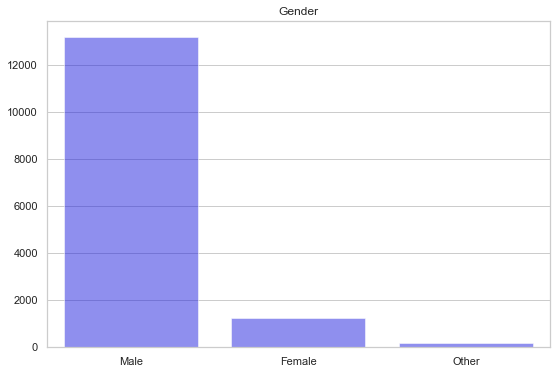

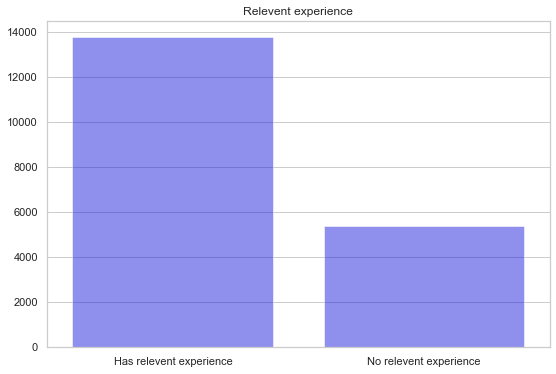

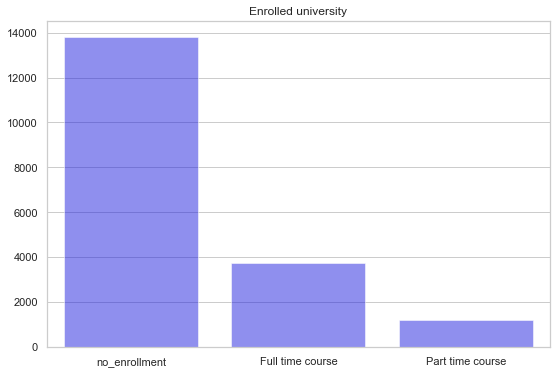

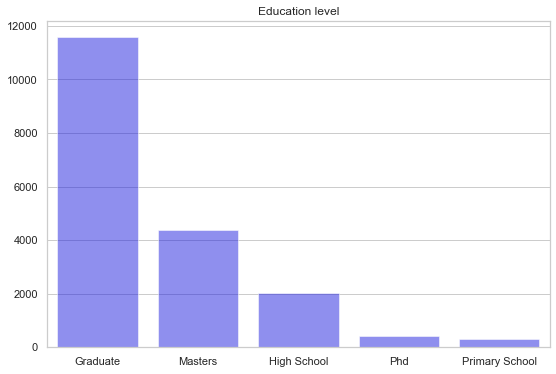

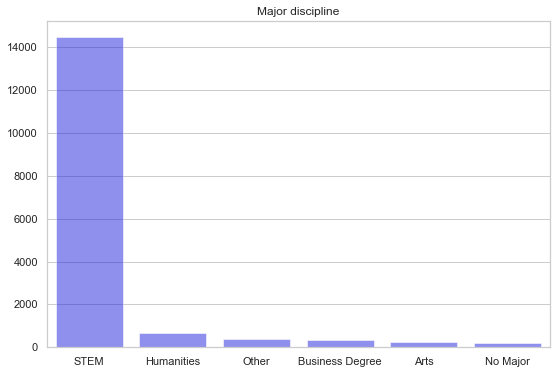

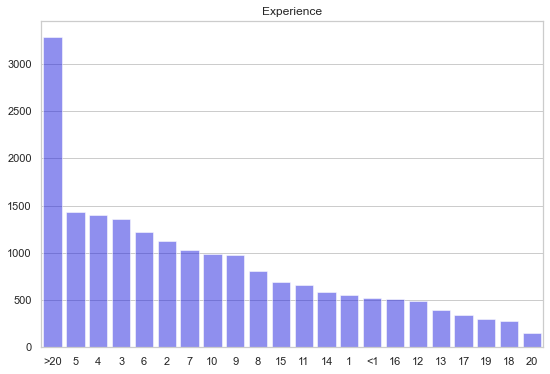

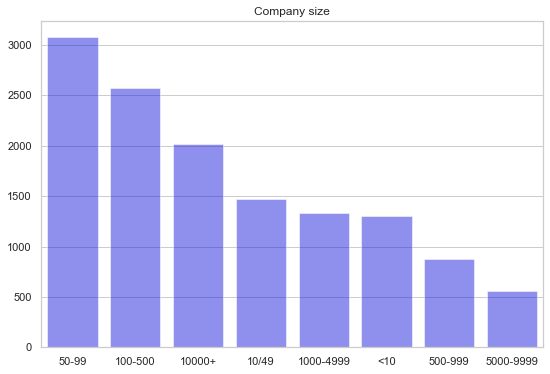

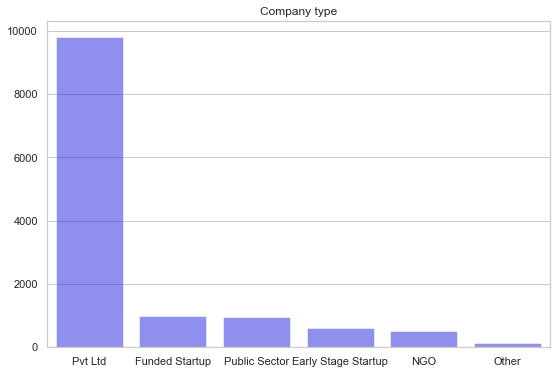

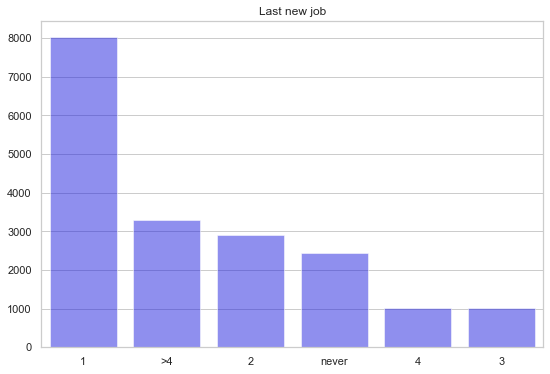

In [9]:
# categorical data
def draw_cat_data(df):
    """this function draw categorical values."""
    for column in cat:
        # get x and y label
        temp =  df[column].value_counts()
        x = temp.index
        y = temp.values
        
        # draw picture 
        plt.figure(figsize=(9,6))
        plt.title(column.capitalize().replace("_"," ") )
        sns.barplot(x=x, y=y, color='blue', alpha=0.5) 
        plt.show()
        
draw_cat_data(df_train)

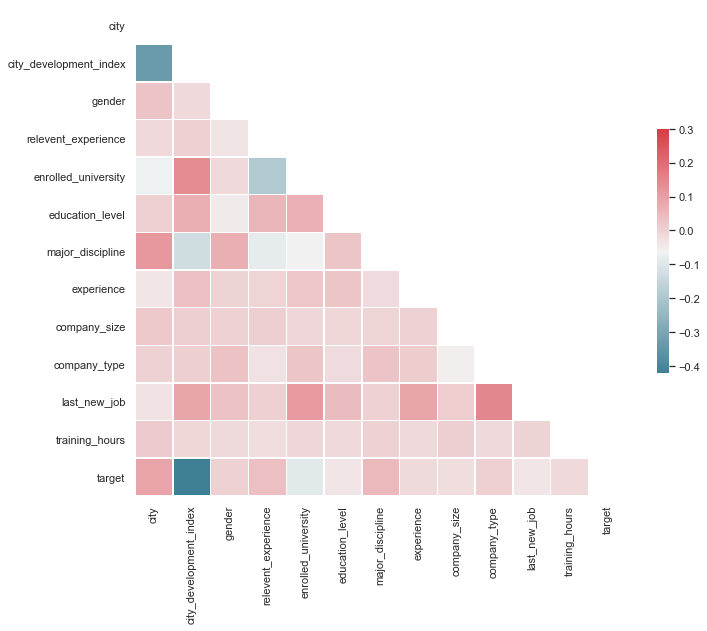

In [10]:
def correlation_heatmap(df):
    # Compute the correlation matrix
    corr = df.corr()

    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(11, 9))

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmax=0.3,
        linewidths=0.5,
        cbar_kws={"shrink": 0.5},
        ax=ax);
    
correlation_heatmap(df_train_notna)

In [11]:
# train_test_split
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression

def baseline_model(X_train, X_test, y_train, y_test, l1_ratios=np.arange(0,1,0.1), is_print=True):
    parameters = {'l1_ratio':l1_ratios}
    
    lr_l1 =LogisticRegression(fit_intercept = False, penalty='l1', solver='liblinear', max_iter = 3000)
    
    lr_clf_l1 = GridSearchCV(lr_l1, 
                             param_grid = parameters, 
                             cv = 3, 
                             return_train_score = True,
                             scoring = 'recall',
                             n_jobs = -1)
    
    lr_clf_l1.fit(X_train, y_train)
    y_pred = lr_clf_l1.predict(X_test)
    
    lr_l1 = lr_clf_l1.best_estimator_
    
    if is_print:
        print('model performance:')
        print(classification_report(y_test, y_pred))

        print('\ntraining result')
        print(pd.DataFrame(lr_clf_l1.cv_results_)[['mean_test_score','param_l1_ratio']].sort_values(by='mean_test_score',ascending=False).head(10))

        print('\ncoefficients ')
        coefficients = pd.DataFrame(index = list(X_train.columns), 
                           data = lr_l1.coef_.reshape(X_train.shape[1],1),
                           columns=['Coefficients'])
        print(coefficients.abs().\
              sort_values(by='Coefficients', ascending=False).head(20))
    return lr_l1 

X_train, X_test, y_train, y_test = train_test_split(df_train_notna.drop(['target'],axis=1), 
                                                    df_train_notna['target'].astype(int), test_size=test_size, random_state=random_state)

_ = baseline_model(X_train, X_test, y_train, y_test)

model performance:
              precision    recall  f1-score   support

           0       0.85      0.99      0.91      2250
           1       0.55      0.08      0.14       437

    accuracy                           0.84      2687
   macro avg       0.70      0.53      0.52      2687
weighted avg       0.80      0.84      0.79      2687


training result
   mean_test_score param_l1_ratio
6         0.092747            0.6
5         0.088924            0.5
1         0.087969            0.1
3         0.087014            0.3
0         0.086050              0
8         0.082233            0.8
2         0.080331            0.2
4         0.076499            0.4
7         0.074570            0.7
9         0.063054            0.9

coefficients 
                        Coefficients
city_development_index      6.122879
major_discipline            0.424610
relevent_experience         0.369604
gender                      0.333976
company_type                0.107182
enrolled_university       

In [12]:
def get_dummy_variables(train, test, cat_ls):
    train_dummies = pd.get_dummies(train[cat_ls],  drop_first = True)
    test_dummies = pd.get_dummies(test[cat_ls], drop_first = True)
    
    train.drop(cat_ls, axis=1, inplace=True)
    test.drop(cat_ls, axis=1, inplace=True)
    
    dummy_ls = list(train_dummies.columns)
    
    train = train.join(train_dummies)
    test = test.join(test_dummies)
    return train, test, dummy_ls

df_train_dummy, df_test_dummy, cat_dummy = get_dummy_variables(df_train, df_test, cat) 
df_train_dummy, df_test_dummy = transfer_cat_type(df_train_dummy, df_test_dummy, cat_dummy)

In [13]:
from sklearn.preprocessing import PolynomialFeatures

def get_poly_variables(train, test, ls, degree=3):
    poly = PolynomialFeatures(degree=degree)
    
    train_ploy = poly.fit_transform(train[ls])
    test_poly = poly.transform(test[ls])
    
    feature_ls = poly.get_feature_names()
    
    for i1, name in enumerate(ls):
        for i2 in range(len(feature_ls)):
            feature_ls[i2] = feature_ls[i2].replace('x'+ str(i1), name)
    
    # drop first order variable
    feature_ls=feature_ls[len(ls)+1: ]
    train_ploy,test_poly = train_ploy[:,len(ls)+1:], test_poly[:,len(ls)+1:]
    
    train = train.join(pd.DataFrame(train_ploy, columns=feature_ls, index=train.index))
    test = test.join(pd.DataFrame(test_poly, columns=feature_ls, index=test.index))
    
    train['intercept'], test['intercept'] = 1, 1
    return train, test

df_train_dummy_poly,df_test_dummy_poly = get_poly_variables(df_train_dummy, df_test_dummy,con)

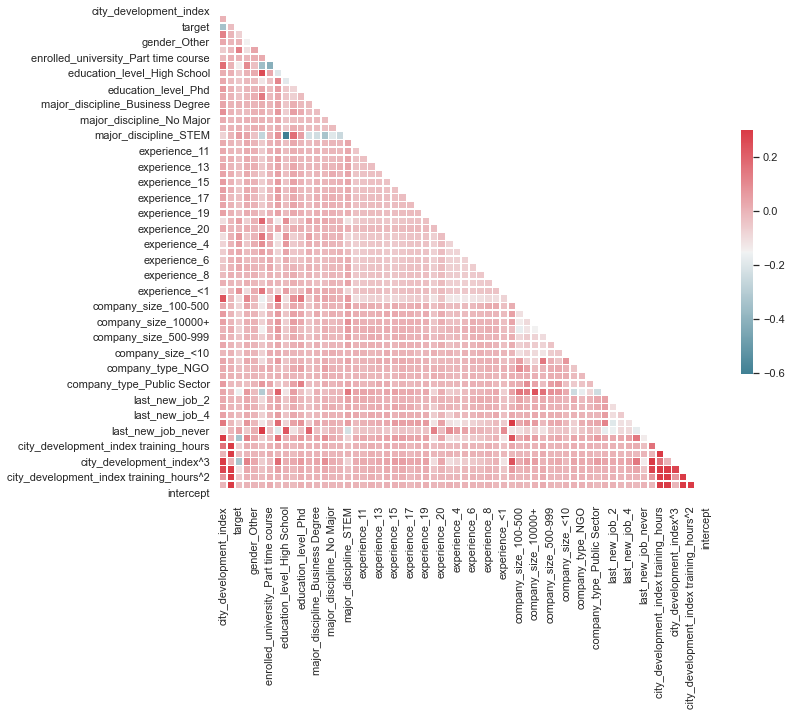

In [14]:
correlation_heatmap(df_train_dummy_poly)

In [15]:
X_train_fe, X_test_fe, y_train_fe, y_test_fe = train_test_split(df_train_dummy_poly.drop(['target','city','enrollee_id'],axis=1), df_train_dummy_poly['target'].astype(int), 
                                                    test_size=0.3, random_state=42)
_ = baseline_model(X_train_fe, X_test_fe, y_train_fe, y_test_fe)

model performance:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85      4300
           1       0.56      0.25      0.35      1448

    accuracy                           0.76      5748
   macro avg       0.68      0.59      0.60      5748
weighted avg       0.73      0.76      0.73      5748


training result
   mean_test_score param_l1_ratio
0         0.287177              0
6         0.286577            0.6
1         0.285675            0.1
7         0.285074            0.7
2         0.284473            0.2
3         0.283873            0.3
4         0.283574            0.4
5         0.283273            0.5
8         0.279366            0.8
9         0.278161            0.9

coefficients 
                                  Coefficients
intercept                             1.677214
city_development_index^3              1.512665
city_development_index^2              1.397898
company_size_<10                      0.956256
company_type_

In [18]:
from sklearn.metrics import precision_recall_fscore_support

def label_encoder_t_grid_search(X_train, X_test, y_train, y_test, N_min_lst=[0, 500, 1000, 2000, 5000, 10000, 20000]):

    feature_cols = []    
    train = X_train.join(y_train)
    test = X_test.join(y_test)
    max_recall = 0
    max_fbeta_score = 0
    
    # encode variables
    for N_min in N_min_lst:
        print("Starting training: {}".format(N_min))
        
        for c in cat_dummy:
            # fit encoder
            be = BetaEncoder(c)
            be.fit(train, 'target')

            # mean
            feature_name = f'{c}_mean'
            train[feature_name] = be.transform(train, 'mean', N_min)
            test[feature_name]  = be.transform(test,  'mean', N_min)
            feature_cols.append(feature_name)

            # mode
            feature_name = f'{c}_mode'
            train[feature_name] = be.transform(train, 'mode', N_min)
            test[feature_name]  = be.transform(test,  'mode', N_min)
            feature_cols.append(feature_name)

            # median
            feature_name = f'{c}_median'
            train[feature_name] = be.transform(train, 'median', N_min)
            test[feature_name]  = be.transform(test,  'median', N_min)
            feature_cols.append(feature_name)    

            # var
            feature_name = f'{c}_var'
            train[feature_name] = be.transform(train, 'var', N_min)
            test[feature_name]  = be.transform(test,  'var', N_min)
            feature_cols.append(feature_name)        

            # skewness
            feature_name = f'{c}_skewness'
            train[feature_name] = be.transform(train, 'skewness', N_min)
            test[feature_name]  = be.transform(test,  'skewness', N_min)
            feature_cols.append(feature_name)    

            # kurtosis
            feature_name = f'{c}_kurtosis'
            train[feature_name] = be.transform(train, 'kurtosis', N_min)
            test[feature_name]  = be.transform(test,  'kurtosis', N_min)
            feature_cols.append(feature_name)

        # according to target values to classify na value
        X_train_encode = train.groupby('target').transform(lambda x: x.fillna(x.mean()))
        X_test_encode  = test.groupby('target').transform(lambda x: x.fillna(x.mean()))

        model = baseline_model(X_train_encode, X_test_encode, y_train, y_test, is_print=False)
        y_pred = model.predict(X_test_encode)
            
        precision, recall, fbeta_score, support = precision_recall_fscore_support(y_test, y_pred, average="weighted")
            
        if (recall > max_recall) & (fbeta_score>=max_fbeta_score):
            print("Fnding best value: {}, in recall rate: {:.4f} and fbeta score: {:.4f}".format(N_min, recall, fbeta_score))
            max_recall = recall
            max_fbeta_score = fbeta_score
            X_train = X_train_encode
            X_test = X_test_encode
            
            X_train.to_csv("X_train.csv")
            X_test.to_csv("X_test.csv")
    return X_train, X_test

X_train_encoder, X_test_encoder = label_encoder_t_grid_search(X_train_fe, X_test_fe, y_train_fe, y_test_fe)

Starting training: 0
Fnding best value: 0, in recall rate: 0.7646 and fbeta score: 0.7307
Starting training: 500
Starting training: 1000
Starting training: 2000
Fnding best value: 2000, in recall rate: 0.7658 and fbeta score: 0.7316
Starting training: 5000
Starting training: 10000
Starting training: 20000


In [ ]:
X_train_encoder